In [84]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [85]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
 
# Address to geographical data
from geopy.geocoders import Nominatim

# Web Scraping and Reading HTML files
from bs4 import BeautifulSoup

# Used with lists
import itertools

# To add delay between quries
import time

# Useful packages that we will use while clustering neighbourhoods
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.metrics import silhouette_score

# To Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported.')

Libraries imported.


### Getting Borrow and neighbourhood information from the WIki data

In [86]:
wiki = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(wiki, 'lxml')
table = soup.find('table', class_='wikitable sortable')
table_rows = table.find_all('tr') 
data = []
for row in table_rows: #loop to extract data int respective class
    td=[]
    for t in row.find_all('td'):
        td.append(t.text.strip())
    data.append(td)
df = pd.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df = df[~df['Borough'].isnull()]  # Data Wrangling. removing nulldata in borrow
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index() #two rows will be combined into one row with the neighborhoods separated with a comma 
!wget -q -O 'Toronto_location.csv'  http://cocl.us/Geospatial_data  # csv geo coord
df_loc = pd.read_csv('Toronto_location.csv')
df_loc.columns = ['PostalCode','Latitude','Longitude']
df_final = pd.merge(df, df_loc, on = 'PostalCode')
df_final.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [88]:
import warnings
warnings.filterwarnings('ignore')
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of Toronto,Ontario are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of Toronto,Ontario are 43.653963, -79.387207.


In [138]:
df_final.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [69]:
df.shape

(103, 3)

In [90]:
# create map of Toronto using latitude and longitude values
# @hidden_cell
map_toronto = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# add markers to map
for lat, lng, nei in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
#map_toronto


# Toronto Neighbourhood

In [91]:
map_toronto

In [92]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The geograpical coordinate of neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The geograpical coordinate of neighborhood_1 are 43.653963, -79.387207.


In [93]:
CLIENT_ID = 'TDGQ0N0A4G1KG43GNKNWDRIL5BFRRJCS4QCETBB01USQL1PW' # your Foursquare ID
CLIENT_SECRET = 'E1LHT0F0DTCMYNRMTMWWVEZ0IM3EVEA3X2OX5HFEVOEU1LQF' # your Foursquare Secret
VERSION = '20180604'

In [94]:
CLIENT_ID 
CLIENT_SECRET

'E1LHT0F0DTCMYNRMTMWWVEZ0IM3EVEA3X2OX5HFEVOEU1LQF'

# Foursquare connection

In [95]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
            

In [96]:
 results = requests.get(url).json()

In [97]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [98]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [99]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Downtown Toronto,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",43.653232,-79.385296
1,Japango,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",43.655268,-79.385165
2,Cafe Plenty,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",43.654571,-79.389450
3,Rolltation,"[{'id': '4bf58dd8d48988d111941735', 'name': 'J...",43.654918,-79.387424
4,Sansotei Ramen 三草亭,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",43.655157,-79.386501


In [100]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Cafe Plenty,Café,43.654571,-79.389450
3,Rolltation,Japanese Restaurant,43.654918,-79.387424
4,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501


In [102]:
# @hidden_cell
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [103]:

# @hidden_cell
toronto_venues = getNearbyVenues(names=df_final['Neighborhood'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude']
                                  )

In [104]:
print(toronto_venues.shape)

(3420, 7)


In [105]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,7,7,7,7,7,7
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",14,14,14,14,14,14
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",10,10,10,10,10,10
"Alderwood,Long Branch",11,11,11,11,11,11


In [29]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 320 uniques categories.


In [106]:
# One hot encoding

toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Sho

In [31]:
toronto_onehot.shape

(3420, 320)

In [107]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Sho

In [108]:
toronto_grouped.shape

(102, 320)

In [109]:
num_top_venues = 5
for hood in toronto_grouped['Neighborhood'][:3]:
    print("----"+hood+"----")
    temp =toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
              venue  freq
0       Coffee Shop  0.09
1              Café  0.06
2  Sushi Restaurant  0.04
3        Steakhouse  0.04
4           Theater  0.03


----Agincourt----
                       venue  freq
0            Badminton Court  0.14
1                     Lounge  0.14
2                  Pool Hall  0.14
3             Breakfast Spot  0.14
4  Latin American Restaurant  0.14


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
                  venue  freq
0           Pizza Place  0.14
1             BBQ Joint  0.07
2                Bakery  0.07
3  Caribbean Restaurant  0.07
4          Noodle House  0.07




In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [111]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,Sushi Restaurant,Restaurant,Bar,Thai Restaurant,Theater,Asian Restaurant,Burger Joint
1,Agincourt,Shanghai Restaurant,Pool Hall,Badminton Court,Coffee Shop,Breakfast Spot,Lounge,Latin American Restaurant,Donut Shop,Diner,Discount Store
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Pizza Place,Fast Food Restaurant,Malay Restaurant,BBQ Joint,Noodle House,Food Court,Caribbean Restaurant,Chinese Restaurant,Shop & Service,Bakery
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Hardware Store,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Pharmacy,Beer Store,Sandwich Place,Liquor Store,Donut Shop
4,"Alderwood,Long Branch",Pizza Place,Convenience Store,Coffee Shop,Gym,Pub,Pharmacy,Sandwich Place,Gas Station,Skating Rink,Women's Store


# Clustering

In [112]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import numpy as np

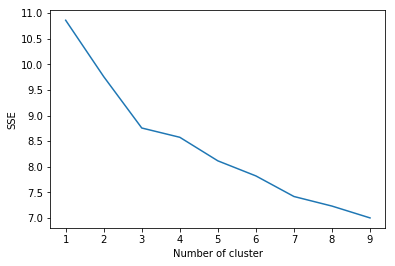

In [113]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(toronto_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

For 2  Clusters  the average silhouette_score is : 0.27346164239150716
For 3  Clusters  the average silhouette_score is : 0.30905214417811605
For 4  Clusters  the average silhouette_score is : 0.30536170461688783
For 5  Clusters  the average silhouette_score is : 0.2832743339631093


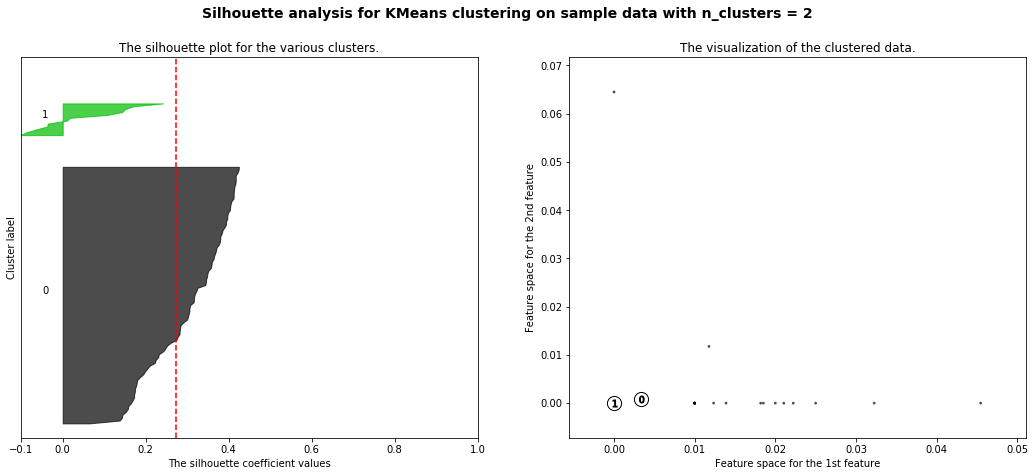

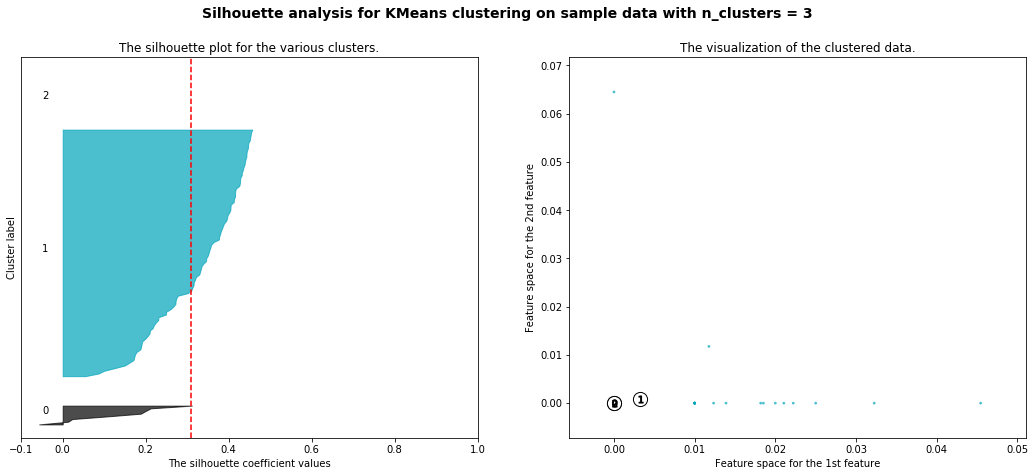

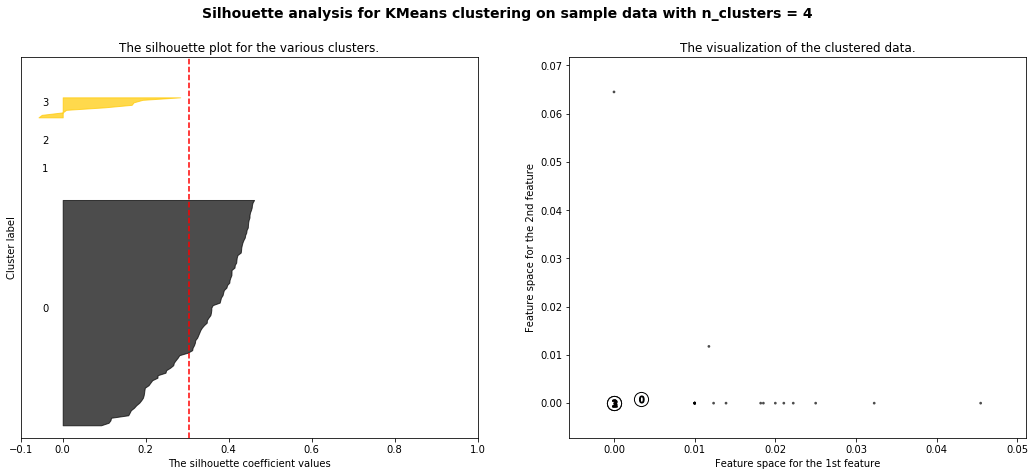

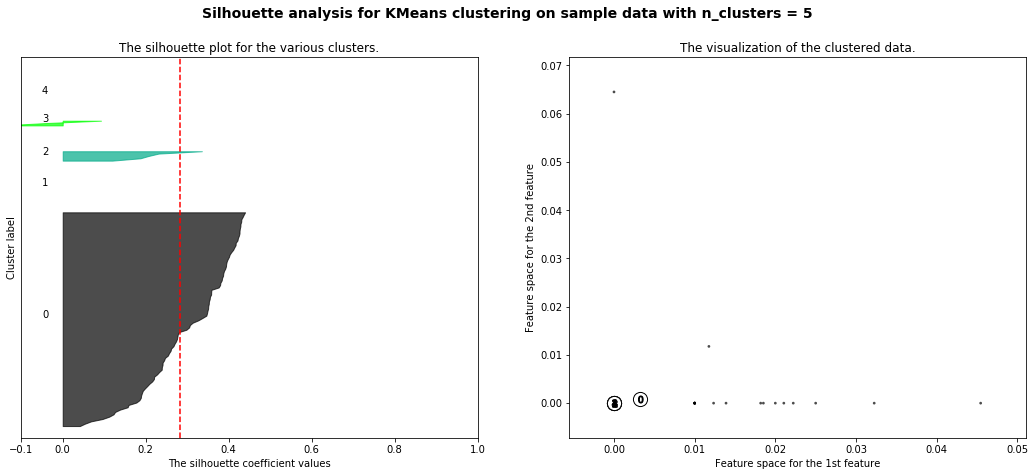

In [114]:
range_n_clusters=[2,3,4,5]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(toronto_grouped_clustering) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(toronto_grouped_clustering)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(toronto_grouped_clustering, cluster_labels)
    print("For", n_clusters, " Clusters  "
          "the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(toronto_grouped_clustering, cluster_labels)

    y_lower = 5
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color1 = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color1, edgecolor=color1, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors2 = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(toronto_grouped_clustering.iloc[:, 0], toronto_grouped_clustering.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors2, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [115]:

kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [ ]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_cl = df_final.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_cl.head()

In [139]:

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_cl = df_final

toronto_cl = toronto_cl.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_cl.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Hobby Shop,Business Service,Coffee Shop,Spa,Bus Station,Construction & Landscaping,Drugstore,Discount Store,Dive Bar
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.0,Breakfast Spot,Burger Joint,Bar,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.0,Pizza Place,Fast Food Restaurant,Thrift / Vintage Store,Park,Rental Car Location,Moving Target,Bus Line,Electronics Store,Mexican Restaurant,Breakfast Spot
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Park,Business Service,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Bakery,Coffee Shop,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Athletics & Sports,Asian Restaurant,Chinese Restaurant


In [141]:
toronto_cl

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Hobby Shop,Business Service,Coffee Shop,Spa,Bus Station,Construction & Landscaping,Drugstore,Discount Store,Dive Bar
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.0,Breakfast Spot,Burger Joint,Bar,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.0,Pizza Place,Fast Food Restaurant,Thrift / Vintage Store,Park,Rental Car Location,Moving Target,Bus Line,Electronics Store,Mexican Restaurant,Breakfast Spot
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Park,Business Service,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Bakery,Coffee Shop,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Athletics & Sports,Asian Restaurant,Chinese Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.0,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Farm,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,0.0,Coffee Shop,Discount Store,Convenience Store,Intersection,Sandwich Place,Bus Line,Light Rail Station,Department Store,Hockey Arena,Hobby Shop
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,0.0,Intersection,Diner,Bakery,Park,Metro Station,Bus Station,Bus Line,Soccer Field,Fast Food Restaurant,Convenience Store
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0.0,Wings Joint,Hardware Store,Chinese Restaurant,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.0,College Stadium,Park,Skating Rink,Diner,Thai Restaurant,General Entertainment,Café,Concert Hall,Drugstore,Discount Store


In [142]:
toronto_cl

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Hobby Shop,Business Service,Coffee Shop,Spa,Bus Station,Construction & Landscaping,Drugstore,Discount Store,Dive Bar
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.0,Breakfast Spot,Burger Joint,Bar,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.0,Pizza Place,Fast Food Restaurant,Thrift / Vintage Store,Park,Rental Car Location,Moving Target,Bus Line,Electronics Store,Mexican Restaurant,Breakfast Spot
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Park,Business Service,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Bakery,Coffee Shop,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Athletics & Sports,Asian Restaurant,Chinese Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.0,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Farm,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,0.0,Coffee Shop,Discount Store,Convenience Store,Intersection,Sandwich Place,Bus Line,Light Rail Station,Department Store,Hockey Arena,Hobby Shop
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,0.0,Intersection,Diner,Bakery,Park,Metro Station,Bus Station,Bus Line,Soccer Field,Fast Food Restaurant,Convenience Store
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0.0,Wings Joint,Hardware Store,Chinese Restaurant,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.0,College Stadium,Park,Skating Rink,Diner,Thai Restaurant,General Entertainment,Café,Concert Hall,Drugstore,Discount Store


In [143]:
toronto_cl1=toronto_cl.dropna().reset_index(drop = True)
toronto_cl1['Cluster Labels'] = toronto_cl1['Cluster Labels'].astype(int)
toronto_cl1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Hobby Shop,Business Service,Coffee Shop,Spa,Bus Station,Construction & Landscaping,Drugstore,Discount Store,Dive Bar
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,Breakfast Spot,Burger Joint,Bar,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Pizza Place,Fast Food Restaurant,Thrift / Vintage Store,Park,Rental Car Location,Moving Target,Bus Line,Electronics Store,Mexican Restaurant,Breakfast Spot
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Park,Business Service,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Bakery,Coffee Shop,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Athletics & Sports,Asian Restaurant,Chinese Restaurant


In [144]:
toronto_cl1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Hobby Shop,Business Service,Coffee Shop,Spa,Bus Station,Construction & Landscaping,Drugstore,Discount Store,Dive Bar
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,Breakfast Spot,Burger Joint,Bar,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Pizza Place,Fast Food Restaurant,Thrift / Vintage Store,Park,Rental Car Location,Moving Target,Bus Line,Electronics Store,Mexican Restaurant,Breakfast Spot
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Park,Business Service,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Bakery,Coffee Shop,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Athletics & Sports,Asian Restaurant,Chinese Restaurant


In [145]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
import matplotlib.colors as colors
# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, nei , cluster in zip(toronto_cl1['Latitude'], toronto_cl1['Longitude'], toronto_cl1['Neighborhood'], toronto_cl1['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#80ffb4', '#ff0000']


# Cluster 1

In [146]:
df1=toronto_cl1.loc[toronto_cl1['Cluster Labels'] == 0,toronto_cl1.columns[[2] + list(range(5, toronto_cl1.shape[1]))]]
df1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge,Malvern",0,Fast Food Restaurant,Hobby Shop,Business Service,Coffee Shop,Spa,Bus Station,Construction & Landscaping,Drugstore,Discount Store,Dive Bar
1,"Highland Creek,Rouge Hill,Port Union",0,Breakfast Spot,Burger Joint,Bar,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
2,"Guildwood,Morningside,West Hill",0,Pizza Place,Fast Food Restaurant,Thrift / Vintage Store,Park,Rental Car Location,Moving Target,Bus Line,Electronics Store,Mexican Restaurant,Breakfast Spot
4,Cedarbrae,0,Bakery,Coffee Shop,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Athletics & Sports,Asian Restaurant,Chinese Restaurant
5,Scarborough Village,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Farm,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant
6,"East Birchmount Park,Ionview,Kennedy Park",0,Coffee Shop,Discount Store,Convenience Store,Intersection,Sandwich Place,Bus Line,Light Rail Station,Department Store,Hockey Arena,Hobby Shop
7,"Clairlea,Golden Mile,Oakridge",0,Intersection,Diner,Bakery,Park,Metro Station,Bus Station,Bus Line,Soccer Field,Fast Food Restaurant,Convenience Store
8,"Cliffcrest,Cliffside,Scarborough Village West",0,Wings Joint,Hardware Store,Chinese Restaurant,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
9,"Birch Cliff,Cliffside West",0,College Stadium,Park,Skating Rink,Diner,Thai Restaurant,General Entertainment,Café,Concert Hall,Drugstore,Discount Store
10,"Dorset Park,Scarborough Town Centre,Wexford He...",0,Fast Food Restaurant,Bakery,Electronics Store,Indian Restaurant,Light Rail Station,Vietnamese Restaurant,Coffee Shop,Gym,Brewery,Pet Store


# Cluster 2

In [147]:
df2=toronto_cl1.loc[toronto_cl1['Cluster Labels'] == 1,toronto_cl1.columns[[2] + list(range(5, toronto_cl1.shape[1]))]]
df2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Woburn,1,Coffee Shop,Park,Business Service,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
20,"Newtonbrook,Willowdale",1,Park,Coffee Shop,Music Venue,Trail,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
24,Parkwoods,1,Park,Food & Drink Shop,Pet Store,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
49,Rosedale,1,Park,Playground,Trail,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
63,"Forest Hill North,Forest Hill West",1,Park,Jewelry Store,Trail,Sushi Restaurant,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run


# Cluster 3

In [148]:
df3=toronto_cl1.loc[toronto_cl1['Cluster Labels'] == 2,toronto_cl1.columns[[2] + list(range(5, toronto_cl1.shape[1]))]]
df3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,"Silver Hills,York Mills",2,Cafeteria,College Rec Center,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [149]:

clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster3":df3["Neighborhood"]
                      })
clusters = clusters.replace(np.nan, '', regex=True)
clusters

,Cluster1,Cluster2,Cluster3
0,"Rouge,Malvern",,
1,"Highland Creek,Rouge Hill,Port Union",,
2,"Guildwood,Morningside,West Hill",,
3,,Woburn,
4,Cedarbrae,,
5,Scarborough Village,,
6,"East Birchmount Park,Ionview,Kennedy Park",,
7,"Clairlea,Golden Mile,Oakridge",,
8,"Cliffcrest,Cliffside,Scarborough Village West",,
9,"Birch Cliff,Cliffside West",,


In [150]:
new_toronto=toronto_cl1.set_index("Neighborhood",drop=True)
new_toronto

,PostalCode,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,
"Rouge,Malvern",M1B,Scarborough,43.806686,-79.194353,0,Fast Food Restaurant,Hobby Shop,Business Service,Coffee Shop,Spa,Bus Station,Construction & Landscaping,Drugstore,Discount Store,Dive Bar
"Highland Creek,Rouge Hill,Port Union",M1C,Scarborough,43.784535,-79.160497,0,Breakfast Spot,Burger Joint,Bar,Women's Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
"Guildwood,Morningside,West Hill",M1E,Scarborough,43.763573,-79.188711,0,Pizza Place,Fast Food Restaurant,Thrift / Vintage Store,Park,Rental Car Location,Moving Target,Bus Line,Electronics Store,Mexican Restaurant,Breakfast Spot
Woburn,M1G,Scarborough,43.770992,-79.216917,1,Coffee Shop,Park,Business Service,Women's Store,Drugstore,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant
Cedarbrae,M1H,Scarborough,43.773136,-79.239476,0,Bakery,Coffee Shop,Indian Restaurant,Thai Restaurant,Caribbean Restaurant,Gas Station,Fried Chicken Joint,Athletics & Sports,Asian Restaurant,Chinese Restaurant
Scarborough Village,M1J,Scarborough,43.744734,-79.239476,0,Fast Food Restaurant,Coffee Shop,Pizza Place,Convenience Store,Farm,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant
"East Birchmount Park,Ionview,Kennedy Park",M1K,Scarborough,43.727929,-79.262029,0,Coffee Shop,Discount Store,Convenience Store,Intersection,Sandwich Place,Bus Line,Light Rail Station,Department Store,Hockey Arena,Hobby Shop
"Clairlea,Golden Mile,Oakridge",M1L,Scarborough,43.711112,-79.284577,0,Intersection,Diner,Bakery,Park,Metro Station,Bus Station,Bus Line,Soccer Field,Fast Food Restaurant,Convenience Store
"Cliffcrest,Cliffside,Scarborough Village West",M1M,Scarborough,43.716316,-79.239476,0,Wings Joint,Hardware Store,Chinese Restaurant,Burger Joint,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


# Conclusion:

As per the above analysis, It is clear that the neughbourhoods listed in cluster 2 best suites for client to chose a location that meets client's requirement since parks, cofee shops, drug stores and trails are the amongst the top 5 most common venues around this neighbourhood. 

Woburn\
Newtonbrook\
Willowdale\
Parkwoods\
Rosedale\
Forest Hill North\
Forest Hill West

However noticed the Hospital is not a most common venue in any of these neighbourhood. 

According to this analysis it is evident that the neghbourhood of Newtonbrook and Willowdale (North York/Postal code:M2) is the most fit location for this client since all venues that cient would want for their new house location are common in this neighbourhood

##### The best suited location to buy new house for client:
###### Newtonbrook and Willowdale (North York/Postal code:M2) 
    